In [1]:
import pandas as pd
import numpy as np
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest
from hftbacktest import Recorder
from hftbacktest.stats import LinearAssetRecord

from src.strategies.glft_pretrained_rf import glft_pre_trained

In [2]:
day_start = 2
day_end = 3
data = []

MAKER_FEE = -0.0001
TAKER_FEE =  0.0005

gamma = 0.01143319447439636
delta = 1
adj1 = 0.9314120055506834
adj2 = 0.43081606500331926
max_position=50

for i in range(day_start, day_end):
    day = str(i) if i > 9 else "0" + str(i)
    day_file = f"../data/daily_processed/deribit_eth_perp_2025-01-{day}.npz"

    data.append(day_file)

day_start_str = str(day_start - 1) if day_start > 10 else "0" + str(day_start - 1)
eod = np.load(f"../data/snapshots/deribit_eth_perp_2025-01-{day_start_str}_eod.npz")['data']

stats = pd.read_csv("../data-generated/depth_stats/daily_stats_25_merged.csv").to_numpy()
train_features = np.load("../data/features/normalized_01_jan.npy")
labels = np.load("../data/features/k_50_deeplob_cat_labels_01_jan.npy") 
print(train_features.shape, labels.shape)

(863997, 100) (863997,)


In [3]:
asset = (
BacktestAsset()
    .data(data)
    .initial_snapshot(eod)
    .linear_asset(1.0)
    # .intp_order_latency(latencies, True)
    .constant_latency(10000, 10000) # Constant latency model (nanoseconds) values inspired from https://roq-trading.com/docs/blogs/2023-01-12/deribit/
    .risk_adverse_queue_model()
    # .power_prob_queue_model(2.0)
    .no_partial_fill_exchange()
    .trading_value_fee_model(MAKER_FEE, TAKER_FEE)
    .tick_size(0.01) # Tick size of this asset: minimum price increasement
    .lot_size(1) # Lot size of this asset: minimum trading unit
    # .roi_lb(0.0) # Sets the lower bound price for the range of interest in the market depth.
    # .roi_ub(3000.0) # Sets the upper bound price for the range of interest in the market depth.
    .last_trades_capacity(10000)
)

hbt = HashMapMarketDepthBacktest([asset])

n_trading_days = day_end - day_start
recorder = Recorder(1, n_trading_days* 1_000_000)

glft_pre_trained(hbt, recorder.recorder, n_trading_days, gamma, delta, adj1, adj2, max_position, stats, train_features, labels)

Hour: 0
Hour: 1
Hour: 2


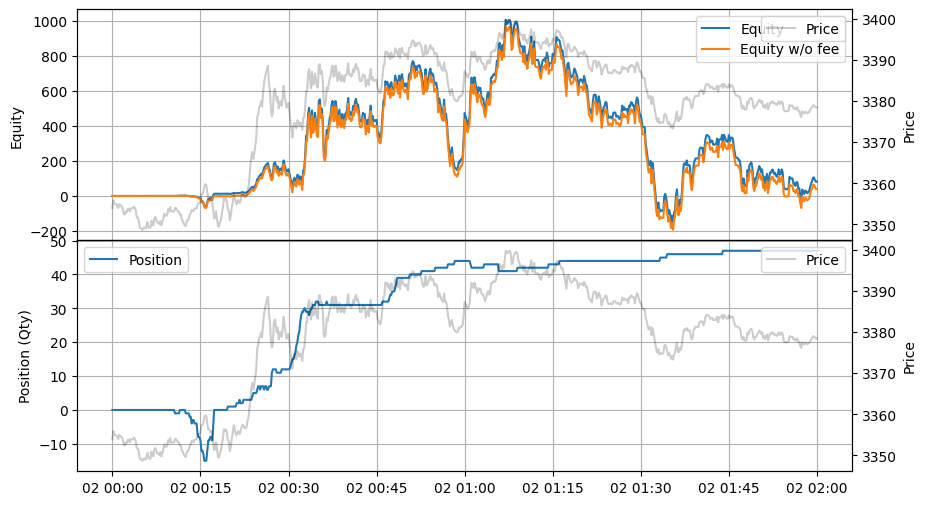

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-02 00:00:00,2025-01-02 02:00:00,4.383442,6.447823,81.246309,1155.901228,1476.0,4.9766e6,0.070288,0.000196,159056.225


In [4]:
stats = LinearAssetRecord(recorder.get(0)).stats()
stats.plot()
stats.summary(pretty=True)